## Set the path to dataset and exclusion keywords for selecting subsets

In [14]:
import os
import numpy as np
import pycatrobin.data.extract as ex
import pycatrobin.analysis.data_analysis as da

## Set Dataset

In [ ]:

# Define the paths to datasets
path =  \
        "../dataset/refined/alldata"
        # "../dataset/refined/alldata_Rh_loading"
        # "../dataset/refined/alldata_synth"
        # "../dataset/refined/alldata_temp"
        # "../dataset/refined/premix"

path_all = "../dataset/refined/alldata"

# Keywords to exclude (Fig 3b)
exclude_keywords = [
    # "_LaboratoryA",  # data from Laboratory A
    # "_LaboratoryB",  # data from Laboratory B
    # "_LaboratoryC",  # data from Laboratory C
    # "_LaboratoryD",  # data from Laboratory D
]

# # Use this in case of single-laboratory SNR analysis (Fig 3c)
# exclude_keywords = [
#     "_LaboratoryA",  # data from Laboratory A
#     "_LaboratoryB",  # data from Laboratory B
#     # "_LaboratoryC",  # data from Laboratory C
#     "_LaboratoryD",  # data from Laboratory D
# ]

exclude_keywords_all = [
    # (Optional) Add more keywords for exclusion in the all data set
]

# Create an instance of DataForGP
dataset = ex.DataForGP(path=path)
dataset.find_excel_files()
dataset.filter_excel_files(exclude_keywords=exclude_keywords, verbose=True)
dataset.construct_dataframe(extensive=False)
# dataset.convert_measured_to_nominal(which_column="Rh_total_mass")
dataset.convert_measured_to_nominal(which_column="Rh_total_mass", allowed_values=np.array([0.02])) # for Round Robin data
dataset.apply_duplicate_groupid(
    exclude_columns=['filename', 'experiment_date', 'location'],
    verbose=False
)

# Create an instance of DataForGP for all data
dataset_all = ex.DataForGP(path=path_all)
dataset_all.find_excel_files()
dataset_all.filter_excel_files(exclude_keywords=exclude_keywords_all, verbose=True)
dataset_all.construct_dataframe(extensive=False)
# dataset.convert_measured_to_nominal(which_column="Rh_total_mass")
dataset_all.convert_measured_to_nominal(which_column="Rh_total_mass", allowed_values=np.array([0.02])) # for Round Robin data
dataset_all.apply_duplicate_groupid(
    exclude_columns=['filename', 'experiment_date', 'location'],
    verbose=False
)

32 excel files were found:
0 files were filtered out:
data indexed 0 is not nominal:  0.020099999999999996 -> 0.02
data indexed 1 is not nominal:  0.0204 -> 0.02
data indexed 4 is not nominal:  0.027000000000000003 -> 0.02
data indexed 5 is not nominal:  0.020099999999999996 -> 0.02
data indexed 9 is not nominal:  0.0199 -> 0.02
data indexed 10 is not nominal:  0.0197 -> 0.02
data indexed 11 is not nominal:  0.0204 -> 0.02
data indexed 13 is not nominal:  0.020099999999999996 -> 0.02
data indexed 14 is not nominal:  0.0207 -> 0.02
data indexed 15 is not nominal:  0.021 -> 0.02
data indexed 16 is not nominal:  0.0204 -> 0.02
data indexed 17 is not nominal:  0.020099999999999996 -> 0.02
data indexed 22 is not nominal:  0.01824 -> 0.02
data indexed 29 is not nominal:  0.0202 -> 0.02
data indexed 31 is not nominal:  0.0199 -> 0.02
32 excel files were found:
0 files were filtered out:
data indexed 0 is not nominal:  0.020099999999999996 -> 0.02
data indexed 1 is not nominal:  0.0204 -> 0.02

## Calculate Target Metrics depending on Selection
* Calculate and add target values into the DataFrame

In [16]:
savgol=False # whether to apply Savitzky-Golay filter or not

# Define quantitative descriptors to capture the magnitude and evolution of catalytic performance.
methods=[
    'AUC',
    'final value',
    'initial value',
    'final slope',
    'initial slope',
    'overall slope',
    ]

# Select Performance metrics to calculate quantitative descriptors for
for column in [
   'CO2 Conversion (%)',
   'CH4 Net Production Rate (mol/molRh/s)',
   'CO Net Production Rate (mol/molRh/s)',
   'Selectivity to CO (%)'
    ]:
    dataset.assign_target_values(
        savgol=savgol, methods=methods,
        column=column, temp_threshold=3.5, init_tos_buffer=0.5, adjacency_slope=1.0,
        )
    dataset_all.assign_target_values(
        savgol=savgol, methods=methods,
        column=column, temp_threshold=3.5, init_tos_buffer=0.5, adjacency_slope=1.0,
        )
    
# Construct unique DataFrame using group IDs
dataset.construct_unique_dataframe(verbose=False)
dataset_all.construct_unique_dataframe(verbose=False)

In [17]:
# Create an instance of DataAnalysis ------
analysis = da.DataAnalysis(dataset=dataset)

# Calculate statistics DataFrame on the basis of GroupID; it determines which data to use as entire dataset
analysis.calculate_statistics_duplicate_group(
    dataset_all=dataset_all,
    total='duplicate',
    verbose=False,
    average_same_location=False,
    # average_same_location=True, # for inter-lab analysis
)

Using duplicate dataset (dataset_all.df_us) for total statistics.


## Plot Signal-to-Noise Ratio (SNR) heatmap

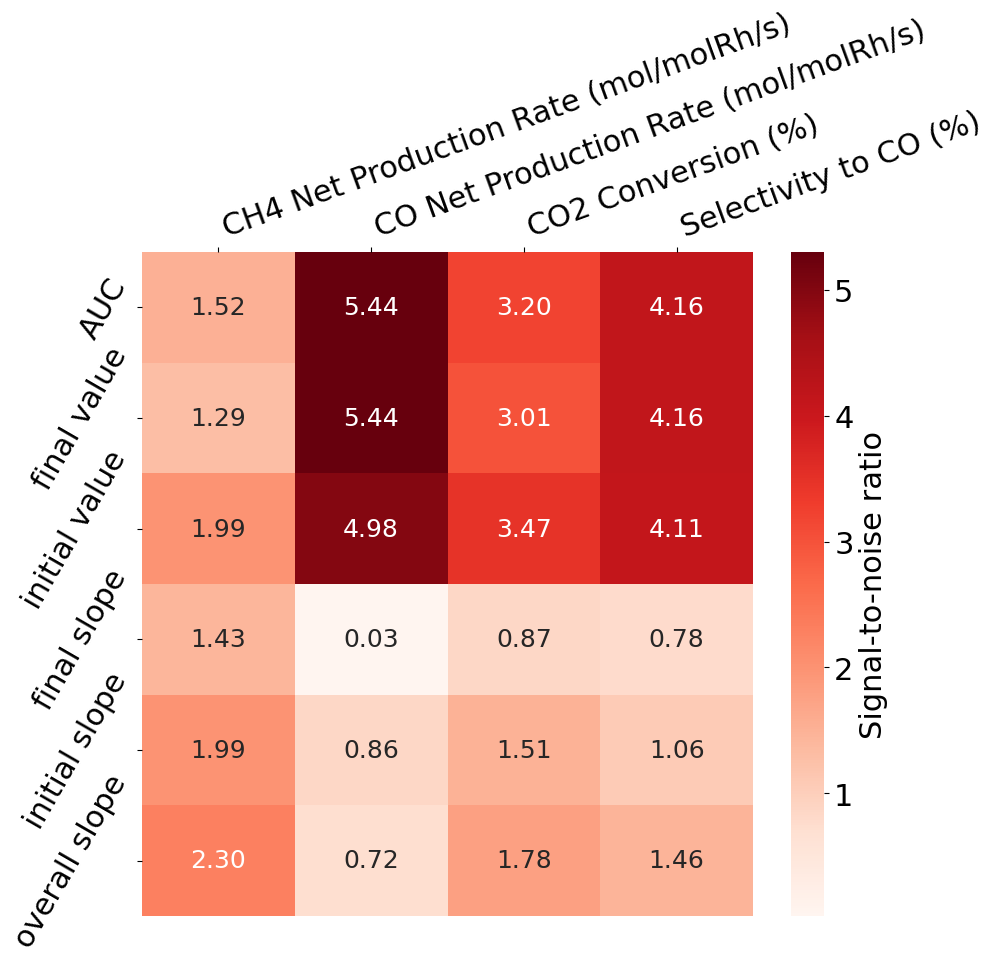

,CH4 Net Production Rate (mol/molRh/s),CO Net Production Rate (mol/molRh/s),CO2 Conversion (%),Selectivity to CO (%)
AUC,1.517037,5.437652,3.203976,4.160591
final value,1.292677,5.435112,3.008155,4.161988
initial value,1.990763,4.981089,3.473799,4.106489
final slope,1.434064,0.026251,0.866408,0.778872
initial slope,1.985472,0.855568,1.507365,1.061830
overall slope,2.304449,0.718003,1.777491,1.456399


In [18]:
%matplotlib inline

# Specify the order of methods and properties to plot
methods=[
    'AUC',
    'final value',
    'initial value',
    'final slope',
    'initial slope',
    'overall slope'
    ]

properties=[
    'CH4 Net Production Rate (mol/molRh/s)',
    'CO Net Production Rate (mol/molRh/s)',
    'CO2 Conversion (%)',
    'Selectivity to CO (%)'
    ]

# Plot heatmap of SNR values
analysis.plot_heatmap(
    methods=methods,
    properties=properties,
    which_to_plot='snr', # std_dev, std_dev_mean_normalized
    snr_type='mu_sigma', # 'std_dev', 'range'
    cmap='Reds', # 'Blues'
    vmax=5.3,
    # vmin=0.0,
)

## Distribution of each target metric
* Please click each panel to see target metric distribution based on violin plot and histogram

In [ ]:
%matplotlib qt

# Compare the standard deviation of the quantitative descriptors for each performance metric
analysis.compare_targets_std_dev(
    target_wise=True,
    snr_type='mu_sigma',
    plot_hist=True, #False,
    # save_fig=True,
    # prefix='',
)

/Users/dongjae/Dropbox/0.Dongjae/04.SUNCAT@SLAC,Standford(2402~)/231128_research/240602_ML_codes/PyCatRobin/pycatrobin/analysis/data_analysis.py:248: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.barplot(data=df_melted[(df_melted['Statistic'] == column) & (df_melted['GroupID'] != 'total')],
/Users/dongjae/Dropbox/0.Dongjae/04.SUNCAT@SLAC,Standford(2402~)/231128_research/240602_ML_codes/PyCatRobin/pycatrobin/analysis/data_analysis.py:248: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.barplot(data=df_melted[(df_melted['Statistic'] == column) & (df_melted['GroupID'] != 'total')],
/Users/dongjae/Dropbox/0.Dongjae/04.SUNCAT@SLAC,Standford(2402~)/231128_research/240602_ML_codes/PyCatRobin/pycatrobin/analysis/data_analysis.py:248: UserWarning: The palette list has more values (7) than needed (6), which may not be intended.
  sns.barplot(data=df_melted[(df_melted['Statistic'] == column) 

## Export the processed data
* AI-ready data sheet is generated, including all the calculated target metrics from each time-on-stream data

In [32]:
# dataset.export_sheet(unique=True)
dataset.export_sheet(unique=False)

,reaction_temp,Rh_weight_loading,Rh_total_mass,synth_method,filename,experiment_date,location,GroupID,CO2 Conversion (%)_AUC,CO2 Conversion (%)_final value,...,CO Net Production Rate (mol/molRh/s)_initial value,CO Net Production Rate (mol/molRh/s)_final slope,CO Net Production Rate (mol/molRh/s)_initial slope,CO Net Production Rate (mol/molRh/s)_overall slope,Selectivity to CO (%)_AUC,Selectivity to CO (%)_final value,Selectivity to CO (%)_initial value,Selectivity to CO (%)_final slope,Selectivity to CO (%)_initial slope,Selectivity to CO (%)_overall slope
0,500.0,0.3,0.02,NP,0p3_RhNP_0p0201mg_500C_20250312_LaboratoryC_RR...,2025-03-12,Laboratory C,3,129.754950,9.787120,...,1.118103,0.040366,0.052492,0.044705,347.113085,50.810445,19.741175,3.561386,3.264498,3.106150
1,400.0,2.0,0.02,WI,2_RhWI_0p0204mg_400C_20250324_LaboratoryD_.xlsx,2025-03-24,Laboratory D,1,60.902591,4.421724,...,1.721066,-0.061232,-0.151987,-0.080214,995.657528,99.615973,92.148193,-0.003725,6.012133,0.746571
2,400.0,2.0,0.02,WI,2_RhWI_0p02mg_400C_20250306_LaboratoryC_RR.xlsx,2025-03-06,Laboratory C,1,84.046181,7.639456,...,1.125005,-0.019559,-0.059418,-0.020424,369.721765,37.558663,35.716900,0.435707,0.411822,0.183088
3,500.0,0.1,0.02,WI,0p1_RhWI_0p02_500C_20250414_LaboratoryA_Right....,2025-04-14,Laboratory A,2,214.335145,20.828780,...,6.273851,-0.019805,0.123926,-0.009352,987.063464,96.930748,99.647666,0.476639,-0.421292,-0.269696
4,600.0,2.0,0.02,WI,2_RhWI_0p027_600C_20250422_LaboratoryA_Right.xlsx,2025-04-22,Laboratory A,6,313.583728,29.310556,...,7.854932,-0.114941,-0.432070,-0.130742,927.150327,98.381768,63.981910,-0.071586,2.677742,3.415056
5,500.0,0.3,0.02,NP,0p3_RhNP_0p0201mg_500C_20250424_LaboratoryB_.xlsx,2025-04-24,Laboratory B,3,80.242586,7.393067,...,1.783017,0.027553,0.126346,0.013760,890.095839,94.149503,58.734646,0.242233,17.292858,3.529818
6,600.0,2.0,0.02,WI,2_RhWI_0p02mg_600C_20250326_LaboratoryD_.xlsx,2025-03-26,Laboratory D,6,211.684447,20.860075,...,5.414713,-0.041834,-0.372068,-0.082572,982.372071,97.918651,93.456979,-0.040934,2.950156,0.446068
7,500.0,0.1,0.02,WI,0p1_RhWI_0p02mg_500C_20250314_LaboratoryD_.xlsx,2025-03-14,Laboratory D,2,216.674552,20.581193,...,5.391405,-0.026778,-0.287007,-0.069920,957.592559,95.730374,95.842795,0.015418,-0.187709,-0.011239
8,600.0,2.0,0.02,WI,2_RhWI_0p02mg_600C_20250423_LaboratoryB_.xlsx,2025-04-23,Laboratory B,6,114.805191,14.118718,...,3.211453,0.132044,-0.670375,0.064840,990.783181,98.820550,98.410903,0.208127,0.585824,0.040854
9,500.0,0.3,0.02,NP,0p3_RhNP_0p0199mg_500C_20250212_LaboratoryD_.xlsx,2025-02-12,Laboratory D,3,86.253291,6.650696,...,1.420056,0.026282,0.163785,0.023253,844.837841,98.283598,32.052885,0.048861,12.986113,6.621232


# Other useful methods

### Plot time-on-stream data (in GUI)

In [ ]:
# Plot the data and the corresponding slopes
%matplotlib qt
dataset.plot_tos_data(column='CO2 Conversion (%)', #'Selectivity to CO (%)',
                      x_max_plot=20, temp_threshold=3.5, init_tos_buffer=0.5, adjacency_slope=1.0,
                      plot_selected=True, plot_slope=False,
                      methods_slope=['initial slope', 'final slope', 'overall slope'], show=True,
                      savgol=savgol,
                      gui=True)

### Plot time-on-stream data which are replicate

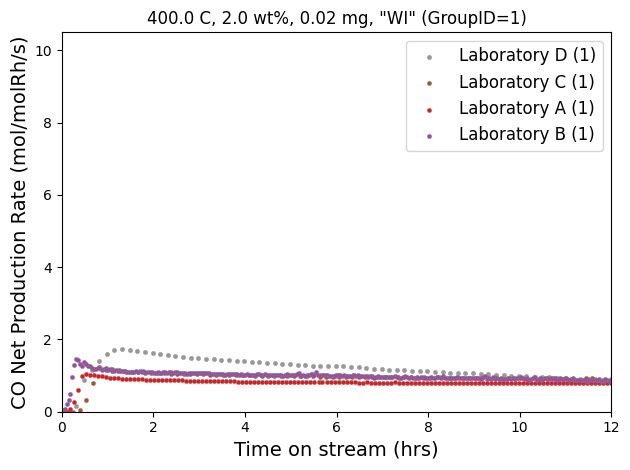

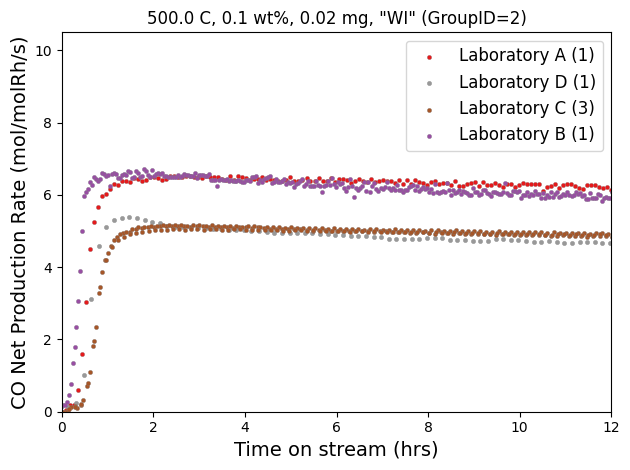

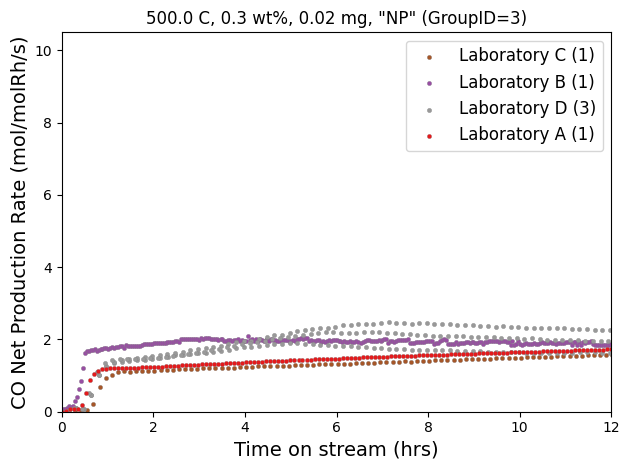

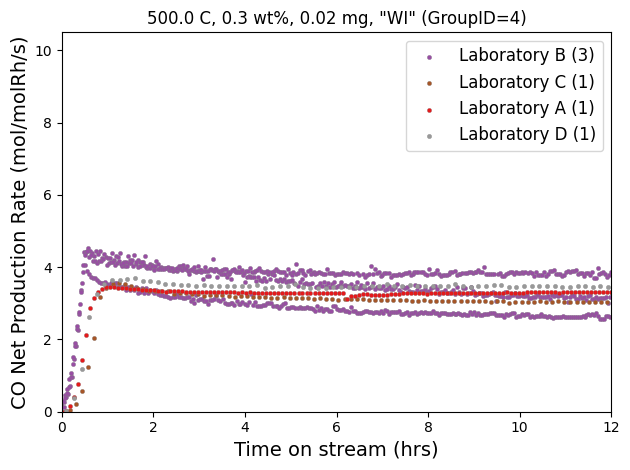

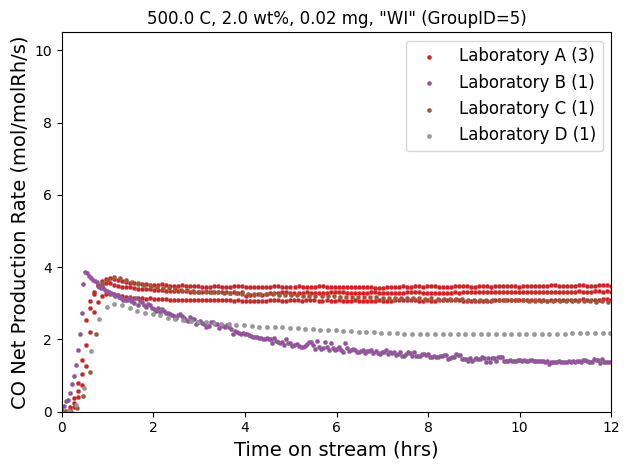

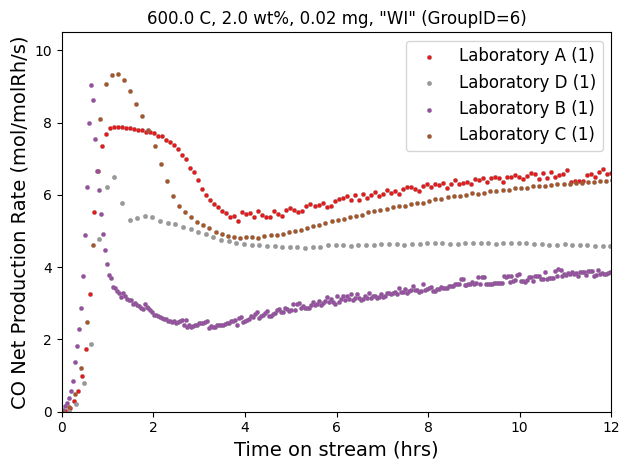

In [14]:
%matplotlib inline
analysis.plot_tos_data_duplicate(column='CO Net Production Rate (mol/molRh/s)', x_max_plot=12, y_max_plot=10.5)

# Examples: 
# analysis.plot_tos_data_duplicate(column='CO Net Production Rate (mol/molRh/s)', x_max_plot=12, y_max_plot=5.5)
# analysis.plot_tos_data_duplicate(column='CO Net Production Rate (mol/molRh/s)', x_max_plot=12, font_scale=1.3)
# analysis.plot_tos_data_duplicate(column='CH4 Net Production Rate (mol/molRh/s)', x_max_plot=12, y_max_plot=10.5)
# analysis.plot_tos_data_duplicate(column='CO2 Conversion (%)', x_max_plot=12, y_max_plot=100)